***
# <font color=red>**Building and Training a Classifier using AutoMLx versus Standard Python**</font>

***

# **1. Import Libraries**

In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import automl
from automl import init

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

<a id='load-data'></a>
# **2. Load the "Did not Attend" dataset**

> ## **Predicting the likelihood a person will not attend the made appointment**

In [26]:
df = pd.read_csv("./DEMO_ML_DNA_RISK.csv")
df.head()

,empi_id,age,gender_female,ethnicity_asian,ethnicity_black,ethnicity_unknown,imd_deprivation_more_deprived,imd_deprivation_unknown,anxiety,severe_mental_illness,sleep_disorders,antidepressants,alcohol_abuse,bmi_value,travel_time,phone_number_in_record,history_of_no_shows,did_not_attend
0,Synth100,57,1,0,0,0,0,0,0,0,0,0,0,19.95,51.863174,1,0,0
1,Synth1000,71,1,0,0,0,1,0,0,0,0,0,0,23.50,84.345688,1,0,0
2,Synth100000,21,0,0,0,0,0,0,0,0,0,0,0,15.66,2.083614,1,0,0
3,Synth100002,33,0,0,0,0,0,0,0,0,0,0,0,25.87,120.735368,1,0,0
4,Synth100004,18,1,0,0,0,0,0,0,0,0,0,0,21.33,59.734349,1,1,1


<Axes: xlabel='did_not_attend', ylabel='count'>

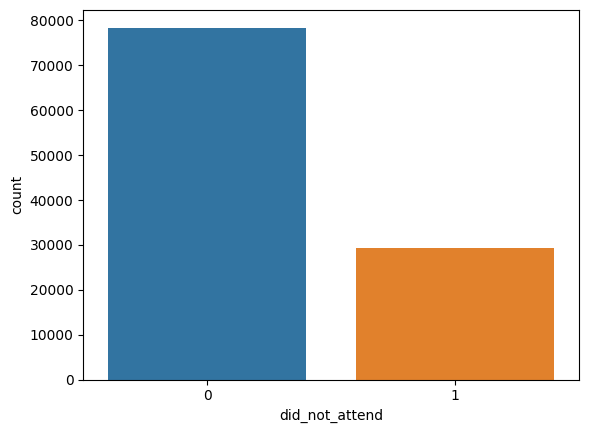

In [27]:
#show target
sns.countplot(df, x="did_not_attend")

In [28]:
xx = df['did_not_attend'].value_counts()
print("% not attending appointment is " + str((xx[1]/(xx[0]+xx[1]))*100))

% not attending appointment is 27.194741532976828


---

# **3. Built ML model using Open Source**

In [29]:
X = df.drop(['did_not_attend', 'empi_id'], axis=1)
y = pd.Series(df['did_not_attend'])

#split data
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=0)


# Standardize features by removing mean and scaling to unit variance:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

# Use the KNN classifier to fit data:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train) 

# Predict y data with classifier: 
y_predict = classifier.predict(X_test)

# Print results: 
#print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict)) 

              precision    recall  f1-score   support

           0       0.77      0.87      0.82     23541
           1       0.46      0.31      0.37      8773

    accuracy                           0.72     32314
   macro avg       0.62      0.59      0.59     32314
weighted avg       0.69      0.72      0.70     32314



> ## **Accuracy without changes is 0.72**

---

# **4. Built ML model using AutoML**

<a id='provider'></a>
AutoML consists of five main modules: 
- **Preprocessing** : Clean, impute, engineer, and normalize features.
- **Algorithm Selection** : Identify the right classification algorithm -in this notebook- for a given dataset, choosing from amongst:
    - AdaBoostClassifier
    - DecisionTreeClassifier
    - ExtraTreesClassifier
    - TorchMLPClassifier
    - KNeighborsClassifier
    - LGBMClassifier
    - LinearSVC
    - LogisticRegression
    - RandomForestClassifier
    - SVC
    - XGBClassifier
    - GaussianNB
- **Adaptive Sampling** : Select a subset of the data samples for the model to be trained on.
- **Feature Selection** : Select a subset of the data features, based on the previously selected model.
- **Hyperparameter Tuning** : Find the right model parameters that maximize score for the given dataset. 

In [30]:
#create automl instance
init(engine='local', check_deprecation_warnings=False)

#create X and Y
X = df.drop(['did_not_attend'], axis=1)
y = pd.Series(df['did_not_attend'])

#split in train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=0)
X_train.shape, X_test.shape

#run the AutoML pipeline
est1 = automl.Pipeline(task='classification', score_metric = 'accuracy')

est1.fit(X_train, y_train)

[2023-11-21 13:03:01,445] [automl.interface] Execution engine (local) has already been initialized. Reinitializing!
[2023-11-21 13:03:01,446] [automl.xengine] Local ProcessPool execution (n_jobs=6)
[2023-11-21 13:03:01,514] [automl.pipeline] Random state (7) is used for model builds
[2023-11-21 13:03:01,554] [automl.pipeline] Dataset shape: (75398, 17)
[2023-11-21 13:03:01,564] [automl.pipeline] Running Auto-Preprocessing
[2023-11-21 13:03:01,697] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (75398, 9), cv: 5
[2023-11-21 13:03:01,721] [automl.pipeline] SVC, KNeighborsClassifier are disabled for datasets with > 10K samples or > 1K features
[2023-11-21 13:03:01,722] [automl.pipeline] Running Model Selection
[2023-11-21 13:03:12,775] [automl.pipeline] Model Selection completed. Selected model: ['XGBClassifier']
[2023-11-21 13:03:12,777] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (75398, 9), Valid Shape: None, CV: 5, Class counts: [54879 20519]
[2023-1

Pipeline(model_list=['DecisionTreeClassifier', 'ExtraTreesClassifier',
                     'GaussianNB', 'LGBMClassifier', 'LogisticRegression',
                     'RandomForestClassifier', 'SVC', 'XGBClassifier',
                     'TorchMLPClassifier', 'CatBoostClassifier'])

In [31]:
est1.print_summary()

Training Dataset size,"(75398, 17)"
Validation Dataset size,None
CV,5
Optimization Metric,accuracy
Selected Features,"Index(['history_of_no_shows'], dtype='object')"
Selected Algorithm,XGBClassifier
Time taken,25.4691
Selected Hyperparameters,"{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'dart', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 3, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 2, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 7, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}"
AutoML version,23.2.2
Python version,"3.8.16 (default, Jun 12 2023, 18:09:05) \n[GCC 11.2.0]"


Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage (GB)
XGBClassifier_HT,75398,1,0.7490,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1}",0.2380,"(0.0, None)"
XGBClassifier_HT,75398,1,0.7490,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5.6244132519034915}",0.4192,"(0.0, None)"
XGBClassifier_HT,75398,1,0.7490,"{'booster': 'gbtree', 'learning_rate': 0.0001, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0}",0.2100,"(0.0, None)"
XGBClassifier_HT,75398,1,0.7490,"{'booster': 'gbtree', 'learning_rate': 0.0001, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0}",0.2331,"(0.0, None)"
XGBClassifier_HT,75398,1,0.7490,"{'booster': 'gbtree', 'learning_rate': 0.10242113515453982, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0}",0.2220,"(0.0, None)"
...,...,...,...,...,...,...
XGBClassifier_AVGRanking_FS,75398,3,0.5138,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.0997,0.0
XGBClassifier_ANOVAF_FS,75398,2,0.5011,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.0017,0.0
XGBClassifier_AdaBoostClassifier_FS,75398,3,0.4740,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.2237,0.0
XGBClassifier_AdaBoostClassifier_FS,75398,2,0.4672,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.0896,0.0


> ## **Accuracy with automated changes is 0.74**